### 1. 기초 통계 과제 (Iris 데이터셋)

In [23]:
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#### 데이터셋 불러오기

In [28]:
iris = sns.load_dataset("iris")

In [29]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [27]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


#### 기술통계량 산출

In [6]:
# petal length의 평균, 표준편차, 최소값, 최대값, 사분위수 출력
iris['petal_length'].describe()

count    150.000000
mean       3.758000
std        1.765298
min        1.000000
25%        1.600000
50%        4.350000
75%        5.100000
max        6.900000
Name: petal_length, dtype: float64

In [8]:
# 그룹별 데이터 개수 확인
iris['species'].value_counts()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

#### 시각화

<Axes: xlabel='species', ylabel='petal_length'>

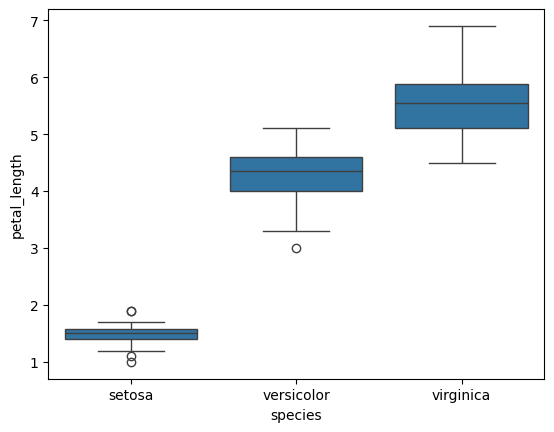

In [10]:
# species별 petal length의 분포를 boxplot으로 시각화
sns.boxplot(x='species', y='petal_length', data=iris)

#### 정규성 검정

In [ ]:
# species별로 shapiro-wilk 검정
species_groups = iris.groupby('species')['petal_length']

for species, group in species_groups:
    stat, p_value = shapiro(group)
    # 각 그룹의 p-value를 출력
    print(f"{species}: p-value = {p_value:.4f}")

setosa: p-value = 0.0548
versicolor: p-value = 0.1585
virginica: p-value = 0.1098


#### 등분산성 검정

In [18]:
# levene 검정을 통해 3개 그룹 간 등분산성 검정
stat, p_value = levene(
    iris[iris['species'] == 'setosa']['petal_length'],
    iris[iris['species'] == 'versicolor']['petal_length'],
    iris[iris['species'] == 'virginica']['petal_length']
)
print(f"stat = {stat:.4f}, p-value = {p_value:.4f}")

stat = 19.4803, p-value = 0.0000


#### 가설 수립

- 귀무가설(H0): 3개 species 간 petal length의 평균은 동일하다.
- 대립가설(H1): 적어도 하나의 species의 petal length 평균은 다른 species와 다르다.

#### ANOVA 실행

In [20]:
# one-way ANOVA
from scipy.stats import f_oneway
stat, p_value = f_oneway(
    iris[iris['species'] == 'setosa']['petal_length'],
    iris[iris['species'] == 'versicolor']['petal_length'],
    iris[iris['species'] == 'virginica']['petal_length']
)
# ANOVA 표 출력
print(f"ANOVA stat = {stat:.4f}, p-value = {p_value:.4f}")

ANOVA stat = 1180.1612, p-value = 0.0000


#### 사후검정 (Tukey HSD)

In [24]:
# Turkey HSD 사후검정
tukey_result = pairwise_tukeyhsd(endog=iris['petal_length'], groups=iris['species'], alpha=0.05)
print(tukey_result)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1     group2   meandiff p-adj lower  upper  reject
---------------------------------------------------------
    setosa versicolor    2.798   0.0 2.5942 3.0018   True
    setosa  virginica     4.09   0.0 3.8862 4.2938   True
versicolor  virginica    1.292   0.0 1.0882 1.4958   True
---------------------------------------------------------


---

### 2. 기초 머신러닝 과제 (신용카드 사기 탐지)

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, average_precision_score

#### 데이터 로드 및 기본 탐색

In [20]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [22]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [23]:
print(data['Class'].value_counts()) 

Class
0    284315
1       492
Name: count, dtype: int64


#### 샘플링

In [24]:
# 사기 거래(Class=1)는 전부 유지
fraud_transactions = data[data['Class'] == 1]
# 정상 거래(Class=0)는 10000건만 무작위 샘플링
normal_transactions = data[data['Class'] == 0].sample(n=10000, random_state=42)
# 새로운 분석용 데이터프레임 생성
sampled_data = pd.concat([fraud_transactions, normal_transactions], ignore_index=True)

In [25]:
sampled_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10487,141415.0,-0.762961,1.897243,1.931378,4.191413,0.103570,1.367957,-0.210296,0.799408,-1.949474,...,-0.217645,-0.639138,-0.096265,0.417441,0.001403,0.194527,0.236362,0.106503,0.76,0
10488,150069.0,-0.299711,1.079933,-0.500521,-0.571127,1.362166,-0.241336,1.061852,-0.055889,0.025168,...,-0.008621,0.287652,-0.302456,-0.025240,-0.037041,0.588618,0.369017,0.266397,25.99,0
10489,160634.0,2.129101,-0.873931,-1.635981,-1.176035,-0.073736,-0.412121,-0.289237,-0.223462,-0.776604,...,-0.034599,-0.262403,0.091163,-1.095939,-0.098260,-0.387646,-0.046397,-0.065703,73.04,0
10490,50297.0,1.127518,0.118124,0.339852,0.599886,-0.359735,-0.421149,-0.161974,0.141529,-0.043080,...,-0.201777,-0.683207,0.175118,0.147933,0.035407,0.097054,-0.021608,0.018880,15.99,0


In [26]:
print(sampled_data['Class'].value_counts())

Class
0    10000
1      492
Name: count, dtype: int64


#### 데이터 전처리

In [27]:
# Amount 변수만 표준화(StandardScaler)하여 새로운 변수 Amount_scaled로 대체
scaler = StandardScaler()
sampled_data['Amount_scaled'] = scaler.fit_transform(sampled_data[['Amount']])
# Amount 변수는 제거
sampled_data.drop(columns=['Amount'], inplace=True)

In [28]:
sampled_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount_scaled
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,1,-0.394650
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1,1.976514
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,1,0.680800
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,1,-0.130191
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1,-0.390168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10487,141415.0,-0.762961,1.897243,1.931378,4.191413,0.103570,1.367957,-0.210296,0.799408,-1.949474,...,-0.217645,-0.639138,-0.096265,0.417441,0.001403,0.194527,0.236362,0.106503,0,-0.391244
10488,150069.0,-0.299711,1.079933,-0.500521,-0.571127,1.362166,-0.241336,1.061852,-0.055889,0.025168,...,-0.008621,0.287652,-0.302456,-0.025240,-0.037041,0.588618,0.369017,0.266397,0,-0.278154
10489,160634.0,2.129101,-0.873931,-1.635981,-1.176035,-0.073736,-0.412121,-0.289237,-0.223462,-0.776604,...,-0.034599,-0.262403,0.091163,-1.095939,-0.098260,-0.387646,-0.046397,-0.065703,0,-0.067259
10490,50297.0,1.127518,0.118124,0.339852,0.599886,-0.359735,-0.421149,-0.161974,0.141529,-0.043080,...,-0.201777,-0.683207,0.175118,0.147933,0.035407,0.097054,-0.021608,0.018880,0,-0.322977


In [29]:
# X, y로 데이터프레임 분리
X = sampled_data.drop(columns=['Class'])
y = sampled_data['Class']

#### 학습 데이터와 데이터 분할

In [30]:
# train_test_split을 사용하여 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [31]:
# 분할된 데이터의 Class 비율 확인
print("Training set:")
print(y_train.value_counts())
print("\nTest set:")
print(y_test.value_counts())

Training set:
Class
0    7999
1     394
Name: count, dtype: int64

Test set:
Class
0    2001
1      98
Name: count, dtype: int64


#### SMOTE 적용

In [32]:
# 학습 데이터에 SMOTE를 적용하여 소수 클래스를 오버샘플링
print("Before SMOTE:", y_train.sum())
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("After SMOTE:", y_train_resampled.sum())

Before SMOTE: 394
After SMOTE: 7999


SMOTE는 소수 클래스(사기)의 합성 샘플을 만들어 클래스 불균형을 완화하는 역할을 한다.

#### 모델 학습

In [ ]:
# 모델 선정 및 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [42]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [43]:
# 예측값과 예측 확률 출력
print("Predictions:", y_pred[:10])
print("Predicted Probabilities:", y_pred_proba[:10])

Predictions: [0 0 0 0 0 0 1 0 0 0]
Predicted Probabilities: [0.02 0.   0.03 0.   0.18 0.   1.   0.   0.03 0.05]


In [44]:
# classification_report로 Precision, Recall, F1-score 확인
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2001
           1       0.95      0.89      0.92        98

    accuracy                           0.99      2099
   macro avg       0.97      0.94      0.96      2099
weighted avg       0.99      0.99      0.99      2099



In [45]:
# average_precision_score로 PR-AUC 계산
ap_score = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score: {ap_score:.4f}")

Average Precision Score: 0.9537
